## Preprocessing:
> Determine if there's a need for preprocessing steps such as normalization or standardization.

> Handle missing data appropriately, either by imputation or removal.




In [3]:
# import handling packages
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import os libraries
import os, shutil, itertools, pathlib
from PIL import Image

In [6]:
# import deep learning tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax

In [7]:
# import ignore warning libs
import warnings
warnings.filterwarnings('ignore')

## Data Splitting:
> Split your dataset into training and validation sets. This is crucial for evaluating the performance of your model.

In [12]:
def get_label_df(path):
    train_path = path
    file_path, labels = list(), list()

    folders = os.listdir(train_path);
    for fold in folders:
        folder_path = os.path.join(train_path, fold)
        files = os.listdir(folder_path)
        for file in files:
            file_path.append(os.path.join(folder_path, file))
            labels.append(fold)

    folder_series = pd.Series(file_path, name="file_paths")
    label_series = pd.Series(labels, name="labels")
    df = pd.concat([folder_series, label_series], axis=1)
    return df


In [13]:
train_path = '../data/classifyData/Training'
test_path = '../data/classifyData/Testing'

In [14]:
train_df, test_df = get_label_df(train_path), get_label_df(train_path)

In [16]:
train_df.head()

,file_paths,labels
0,../data/classifyData/Training/meningioma/Tr-me...,meningioma
1,../data/classifyData/Training/meningioma/Tr-me...,meningioma
2,../data/classifyData/Training/meningioma/Tr-me...,meningioma
3,../data/classifyData/Training/meningioma/Tr-me...,meningioma
4,../data/classifyData/Training/meningioma/Tr-me...,meningioma


In [17]:
test_df.head()

,file_paths,labels
0,../data/classifyData/Training/meningioma/Tr-me...,meningioma
1,../data/classifyData/Training/meningioma/Tr-me...,meningioma
2,../data/classifyData/Training/meningioma/Tr-me...,meningioma
3,../data/classifyData/Training/meningioma/Tr-me...,meningioma
4,../data/classifyData/Training/meningioma/Tr-me...,meningioma


In [19]:
train, valid = train_test_split(train_df, 
                                train_size = 0.8,
                                shuffle = True,
                                random_state = 42
                               )

In [22]:
image_size = (244, 244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train , 
                                       x_col = 'file_paths' , 
                                       y_col = 'labels' , 
                                       target_size = image_size ,
                                      class_mode = 'categorical' , 
                                       color_mode = 'rgb' , 
                                       shuffle = True , 
                                       batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , 
                                       x_col = 'file_paths' , 
                                       y_col = 'labels' , 
                                       target_size = image_size , 
                                       class_mode = 'categorical',
                                       color_mode = 'rgb' , 
                                       shuffle= True, 
                                       batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df , 
                                      x_col= 'file_paths' , 
                                      y_col = 'labels' , 
                                      target_size = image_size , 
                                      class_mode = 'categorical' , 
                                      color_mode= 'rgb' ,
                                      shuffle = False , 
                                      batch_size = batch_size)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 5712 validated image filenames belonging to 4 classes.


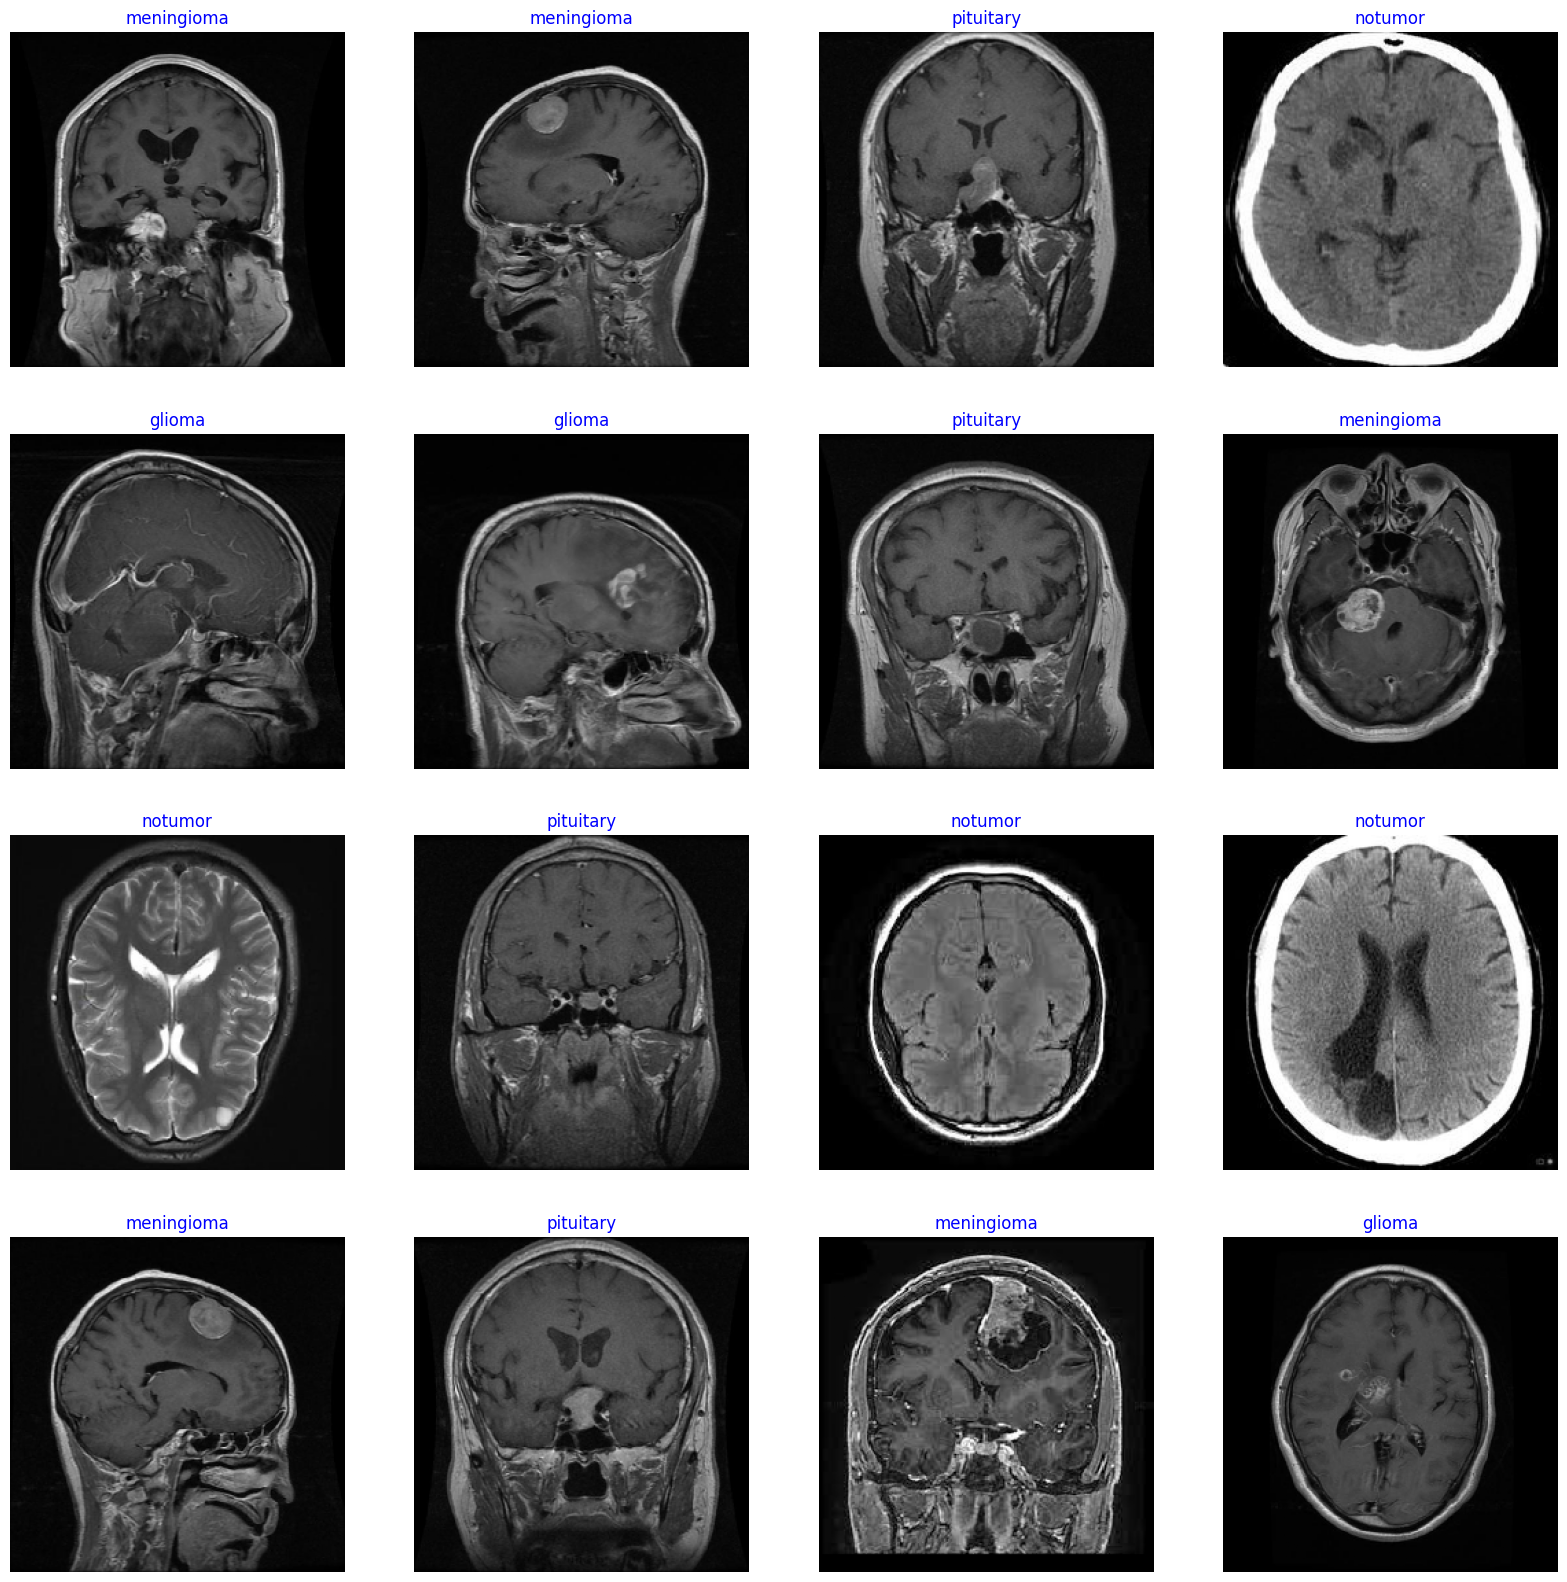

In [23]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();



In [ ]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

In [ ]:
Epochs = 10

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)


In [ ]:


train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [ ]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))